In [1]:
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

## Table of contents <a id='TOC'></a>

### [I. Data preparation and initial exploration](#section1)
### [II. Sentiment analysis](#section2)
### [2A. Word cloud and analysis](#section2a)
### [2B. Frequency count of the most frequent words](#section2b)
### [III. Conclusion and recommendation](#section3)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-vaccine-news-reddit-discussions/comments.csv


<a id='section1'></a>
### I. Data preparation and initial exploration.

In [3]:
df=pd.read_csv("/kaggle/input/covid19-vaccine-news-reddit-discussions/comments.csv")

In [4]:
df.head()

,post_id,post_author,post_date,post_title,post_score,post_permalink,post_url,comment_id,comment_author,comment_date,comment_parent_id,comment_edited,comment_score,comment_body
0,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfx8br4,AutoModerator,2020-12-15 14:21:21,t3_kdmkbz,False,1,"This post appears to be about vaccines, please..."
1,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfx930g,Hothabanero6,2020-12-15 14:28:43,t3_kdmkbz,False,1784,Who's ahead in the pool for the third vaccine ...
2,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfxaiv8,jsinkwitz,2020-12-15 14:42:16,t3_kdmkbz,False,1905,"""asymptomatic infection was reduced by 63 perc..."
3,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfxglf1,TheyreGoodDogsBrent,2020-12-15 15:36:09,t3_kdmkbz,False,3503,> and appears to prevent the spread of the vir...
4,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfxr0fa,BG1234567,2020-12-15 17:01:14,t3_kdmkbz,False,326,The fact that there are multiple companies mak...


In [5]:
df.shape

(30949, 14)

#### Time frame that the dataset covers:

In [6]:
print("Time frame of the initial posts: ", df[["post_date"]].min().values,", ",df[["post_date"]].max().values,".")

Time frame of the initial posts:  ['2020-11-20 11:51:35'] ,  ['2021-01-10 18:16:07'] .


#### The dataset covers posts made between 11:51:35,11/20/2020 and 20:37:34, 1/9/2021.

In [7]:
print("Time frame of the comments to the post: ", df[["comment_date"]].min().values,", ",df[["comment_date"]].max().values,".")

Time frame of the comments to the post:  ['2020-11-20 12:00:08'] ,  ['2021-01-11 05:03:48'] .


#### The dataset covers comments made between 12:00:08, 11/20/2020 to 2:56:37, 2/10/2021.

In [8]:
comment_count=pd.DataFrame(df.groupby("post_title")["comment_body"].count()).reset_index().sort_values(by="comment_body",ascending=False).reset_index(drop=True)
comment_count

,post_title,comment_body
0,First doses of Pfizer coronavirus vaccine has ...,499
1,Covid-19: Oxford University vaccine shows 70% ...,496
2,"Moderna's vaccine is highly effective, FDA say...",495
3,Pfizer's Coronavirus vaccine arrive in Chicago...,495
4,Just Under Three Million Will Get COVID-19 Vac...,495
...,...,...
248,The Lancet: Oxford COVID-19 vaccine is safe an...,3
249,German scientist Özlem Türeci was focused on c...,3
250,FDA Takes Additional Action in Fight Against C...,2
251,‘Still waiting for my turn’: Primary care doct...,2


In [9]:
import plotly.express as px
fig = px.histogram(comment_count, x="comment_body",title="Distribution of comment counts by title")
fig.show()

#### Most of the posts had less than 400 comments, but there were also 20 initial posts that had more than 400 comments.

[Back to table of content](#TOC)

<a id='section2'></a>
### II. Sentiment analysis

In [10]:
stopwords = set(STOPWORDS)

In [11]:
stopwords.add('>')
stopwords.add('\n>')
stopwords.add("\n\n")
stopwords.add("!")
stopwords.add("“")
stopwords.add("+")
stopwords.add("will")
stopwords.add("still")
stopwords.add("even")
stopwords.add("think")
stopwords.add("getting")
stopwords.add("going")
stopwords.add("said")
stopwords.add("new")
stopwords.add("really")
stopwords.add("know")
stopwords.add("well")
stopwords.add("now")
stopwords.add("need")
stopwords.add("already")
stopwords.add("actually")
stopwords.add("probably")
stopwords.add("got")
stopwords.add("got")
stopwords.add("likely")
stopwords.add("way")
stopwords.add("everyone")

<a id='section2a'></a>
### 2A. World Cloud and analysis.

In [12]:
text=df["comment_body"].to_csv()
comment_wc = WordCloud(
    background_color='white',
    max_words=1000,
    stopwords=stopwords
)
comment_wc.generate(text)

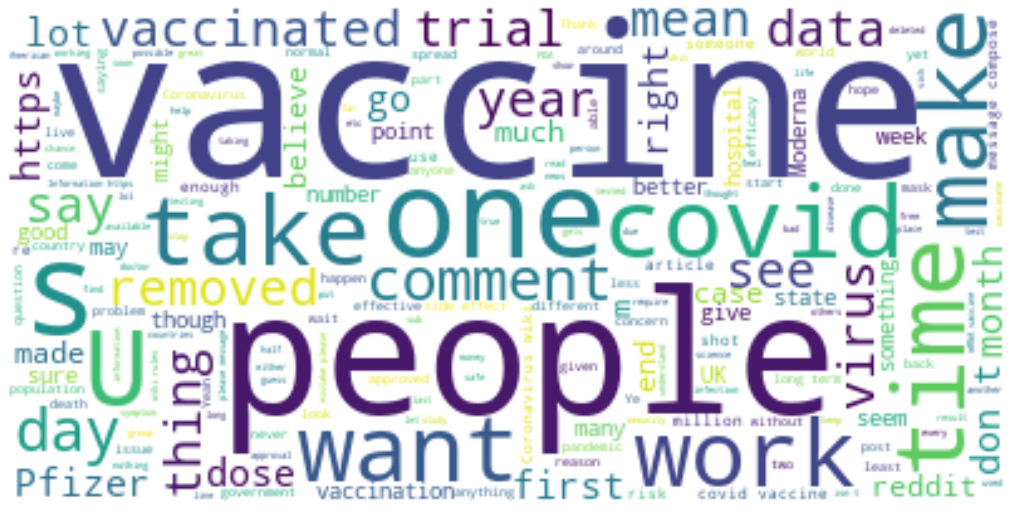

In [13]:
plt.figure(figsize=(18,18))
plt.imshow(comment_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### What we can get from the world cloud illustration:
#### 1. People were probably comparing the Pfizer vaccine to the Moderna vaccine, since the names of both vaccines appeared in the word cloud.
#### 2. The Reddit users knew that the vaccines require two doses, since we see words such as "dose","first","two".
#### 3. The Reddit users also talked abou the vaccine trials. The word "trial" was one of the bigger words in the word cloud, more visibly than even "Moderna". That means the word "trail" appeared highly frequently in the Reddit users' comments.
#### 4. Awareness of the Pfizer vaccine was higher than awareness of the Moderna vaccine.
#### 5. Data is another more visible word. If we look harder, we also see words such as "efficacy", "risk". Taken together, it appeared that the Reddit users were concerned about the efficacy as well as risk of the vaccine, i.e., side effects, and they wanted to see more data.

[Back to table of content](#TOC)

<a id='section2b'></a>
### 2B. Frequency counts of the most common words.

#### The frequency count may shed additional insights on the overall sentiment of the Reddit users.

In [14]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer # RegexpTokenizer will ignore the punctuation marks.

In [15]:
# Use SnowballStemmer to stem the words back to their root forms. This will prevent "good" and "Good" to be counted as two different words.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [16]:
# Pass the comment body text through the stopwords filter and SnowballStemmer.
tokenizer = RegexpTokenizer(r'\w+')
word_tokens = tokenizer.tokenize(text) 
filtered_sentence = [w for w in word_tokens if not w in stopwords] 

filtered_sentence = [] 

for w in word_tokens: 
    if w not in stopwords: 
        w=stemmer.stem(w)
        filtered_sentence.append(w) 

In [17]:
# Convert text to string.
def listToString(s):  
    

    str1 = " " 
    
  
    return (str1.join(s)) 

In [18]:
split_it =listToString(filtered_sentence).split() 

In [19]:
# Count the frequency of each split.
from collections import Counter 
Counter = Counter(split_it) 

In [20]:
# The 150  most comment words.
most_occur = Counter.most_common(150) 

In [21]:
frequentwords=pd.DataFrame(most_occur).rename(columns={0:"Words",1:"Frequencies"})

In [22]:
frequentwords

,Words,Frequencies
0,i,20287
1,vaccin,18151
2,t,11873
3,s,11265
4,peopl,7783
...,...,...
145,compos,793
146,in,793
147,less,792
148,death,791


In [23]:
# Drop the words that escaped the stopwords filter.
frequentwords.drop(index=frequentwords[frequentwords['Words']=="i"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="t"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="s"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="the"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="it"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="don"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="https"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="m"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="re"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="if"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="we"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="this"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="that"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="they"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="say"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="you"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="thing"].index.tolist(), inplace = True)
frequentwords.drop(index=frequentwords[frequentwords['Words']=="much"].index.tolist(), inplace = True)

In [24]:
# Words that repeated at least 1200 times.
frequentwords[frequentwords["Frequencies"]>=1200].shape

(60, 2)

In [25]:
frequentwords[frequentwords["Frequencies"]>=1200]

,Words,Frequencies
1,vaccin,18151
4,peopl,7783
8,one,3588
9,covid,3444
11,dose,3243
14,take,2516
15,time,2439
16,effect,2438
17,make,2410
19,work,2345


#### The frequency counts re-affirm what was discovered from the word cloud illustration:
#### 1. "Pfizer" was mentioned 1,916 times; Moderna was mentioned 1,212 times. --> Awareness of the Pfizer vaccine was higher than awareness of the Moderna vaccine.
#### 2. Reddit users knew the vaccines required two shots, as evidenced by frequent appearances of words such as "one", "dose","first","shot". These words might be words we would want to stop appearing in other context, but in the context of COVID vaccines, these words convey very powerful information about people's sentiment and what they know.
#### 3. The level of concern about risk should not be ingored: the word "risk" appeared 1,312 times, more often than the word "Moderna"; the word "approv" (referring to approval by the FDA) appeard 1,807 times; the word "effect" (possibly referring to potential side effect) appeared 2,433 times.
#### 4. People wanted more data, transparent data. The word "data" appeard 1,816 times.

[Back to table of content](#TOC)

### III. Conclusion and recommendation. <a id='section3'></a>

#### Vaccine rollout in the U.S. has been frustratingly slower than initially expected, while both daily new cases and daily death toll hit new records. The  need to successfully roll out the vaccine has never been more urgent. As the sentiment analysis on the Reddit comments shows, there is still a certain level of vaccine scepticism in the public. That might be one of the reasons why vaccine roll out in the U.S. has not been as expeditiously as expected. What the elected leaders, administrators and pharmaceutical companies want to do is to launch aggressive public education campaigns about how the vaccine works, its efficacy and potential but very rare chance of severe side effects. At the same time, release more data, please. Otherwise, vaccine roll out in the U.S. will continue to be frustratingly slow.

[Back to table of content](#TOC)